In [1]:
print(sys.executable)

c:\Users\valen\Documents\model22\Scripts\python.exe


In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as mtick
from matplotlib.cm import get_cmap
import addcopyfighandler

from IPython.core.display import HTML
from IPython.display import display

import model2 as mod
import model_fsolve as modf

In [3]:
import fluids as fds

In [4]:
par = {}

par["eps"] = 0.001

par["ref"] = 1

par["rho"] = 997 # kg/m3
par["nu"] = 0.896*1e-6 # at 25°C, in m2/s https://www4.ac-nancy-metz.fr/physique/ancien_site/Tp-phys/Term/TP-fluid/visco-eau.htm
par["eta"] = par["rho"]*par["nu"]

In [5]:
# Heat exchanger inputs --------------------------------------------------

# REAL SPRING
# -----------

par["N"] = 165

par["Lx"] = 1.39985 # longueur d'un canal en m, not used in the row calculation
par["Ly"] = 0.0008157 # distance inter canaux en m

# pour le SPRING, avec 1 mm d'écart entre chaque duo de risers, et 5 mm de largeur par riser, ça fait 989 mm de largeur

par["h_man"] = 0.010 # SPRING en vrai c'est 0.010
par["l_man"] = 0.022

par["Dx"] = 0.00476 # m, not used in the row calculation
par["Din"] = (2*par["h_man"]*par["l_man"])/(par["h_man"]+par["l_man"]) # m
par["Dout"] = par["Din"] # m

par["theta"] = 90.

par["rough"] = 0.0015 # PVC/plastic pipe absolute roughness is 0.0015

In [6]:
# Manifold tubulaire

par["Ax"] = math.pi*(par["Dx"]/2)**2
par["Ain"] = math.pi*(par["Din"]/2)**2
par["Aout"] = math.pi*(par["Dout"]/2)**2

par["a_x"] = 84.7/800
# par["a"] = 0.
par["b_x"] = 5.36/800

# dP (Pa) = (rho/2) (a_x u**2 + b_x u) its the pressure loss function of a heat exchanger

par["sch"] = "exchanger"

In [6]:
# Manifold rectangulaire (SPRING ou autre)

par["Ax"] = math.pi*(par["Dx"]/2)**2
par["Ain"] = par["h_man"]*par["l_man"]
par["Aout"] = par["Ain"]

par["a_x"] = 84.7/800
# par["a"] = 0.
par["b_x"] = 5.36/800

# dP (Pa) = (rho/2) (a_x u**2 + b_x u) its the pressure loss function of a heat exchanger

par["sch"] = "exchanger"

In [7]:
# 'Crane' or 'perso'
par['method'] = 'Crane'

# Listes de taille par["N"]

par['Kxin'] = []
par['Kyin'] = []
par['Kxout'] = []
par['Kyout'] = []

In [ ]:
# Test d'un seul débit

par["QF"] = 100/3600000 # m3/s (0.000278 m3/s = 1000 L/h) (le premier nombre est en L/h)
# Speed and Reynolds at inlet manifold
par["U"] = par["QF"]/par["Ain"]
par["Reman"] = par["U"]*(par["rho"]*par["Din"])/par["eta"]
tabl,res = modf.PL_fsolve(par,par["sch"],True)

In [8]:
# Liste de plusieurs débits

# list_k = np.linspace(1e-6,5*1e-6,10)
# list_k = np.linspace(1e-8,1e-6,20)
list_Q = [10/3600000,50/3600000,100/3600000,150/3600000,200/3600000] # m3/s
list_Q_L = 3600000*np.array(list_Q)

list_PL = []
list_mn = []
list_std = []
list_tabl = []

In [9]:
print(list_Q)
print(list_Q_L)

[2.777777777777778e-06, 1.388888888888889e-05, 2.777777777777778e-05, 4.1666666666666665e-05, 5.555555555555556e-05]
[ 10.  50. 100. 150. 200.]


In [10]:
# Model fsolve

for Q in list_Q:
    print(Q)
    par["QF"] = Q
    # Speed and Reynolds at inlet manifold
    par["U"] = par["QF"]/par["Ain"]
    par["Reman"] = par["U"]*(par["rho"]*par["Din"])/par["eta"]

    tabl,res = modf.PL_fsolve(par,par["sch"],False)
    list_PL.append(res)
    list_tabl.append(tabl)

    list_mn.append(tabl['qx'].mean()) # fow rate qx is in L/h
    list_std.append(tabl['qx'].std())


2.777777777777778e-06
1.388888888888889e-05
2.777777777777778e-05
4.1666666666666665e-05
5.555555555555556e-05


c:\Users\valen\Documents\model22\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [19]:
rho = par['rho']

for q in range(len(list_Q)):
    PLq = list_PL[q]

    lin_in = []
    lin_x = []
    lin_out = []
    lin_in_cum = []
    lin_out_cum = []
    sing = []

    tab = list_tabl[q]

    Qin = []
    Qout = []
    for i in range(par["N"]):
        Qin.append(sum([tab['qx'][i] for j in range(0,i+1)]))
        Qout.append(sum([tab['qx'][i] for j in range(i,par["N"])]))

    tab['Qin'] = Qin
    tab['Qout'] = Qout

    for i in range(par["N"]):
        Qin_i = tab['Qin'][i]
        Qout_i = tab['Qout'][i]
        qx_i = tab['qx'][i]

        uin_i = Qin_i/par['Ain']
        ux_i = qx_i/par['Ax']
        uout_i = Qout_i/par['Aout']

        Rein_i = fds.core.Reynolds(uin_i,par['Din'],par['rho'],mu=par['eta'])
        Rex_i = fds.core.Reynolds(ux_i,par['Dx'],par['rho'],mu=par['eta'])
        Reout_i = fds.core.Reynolds(uout_i,par['Dout'],par['rho'],mu=par['eta'])
        fin_i = fds.friction.friction_factor(Re = Rein_i)
        fx_i = fds.friction.friction_factor(Re = Rex_i)
        fout_i = fds.friction.friction_factor(Re = Reout_i)

        ain_i = fin_i*(par['Ly']/par['Din'])
        ax_i = fx_i*(par['Lx']/par['Dx'])
        aout_i = fout_i*(par['Ly']/par['Dout'])

        lin_in.append((rho/2)*ain_i*uin_i**2)
        lin_x.append((rho/2)*ax_i*ux_i**2)
        lin_out.append((rho/2)*aout_i*uout_i**2)

    tab['lin_in'] = lin_in
    tab['lin_x'] = lin_x
    tab['lin_out'] = lin_out

    for i in range(par["N"]):
        lin_in_cum.append(sum([lin_in[j] for j in range(i,par["N"])]))
        lin_out_cum.append(sum([lin_out[j] for j in range(0,i)]))

    tab['lin_in_cum'] = lin_in_cum
    tab['lin_out_cum'] = lin_out_cum

    for i in range(par["N"]):
        sing.append(PLq-tab['lin_in_cum'][i]-tab['lin_x'][i]-tab['lin_out_cum'][i])
    
    tab['sing'] = sing

In [21]:
print(list_PL)
print(list_tabl[0])

[0.7665524783605712, 5.177933741596064, 16.11781138319649, 37.0269098442076, 63.667653774741716]
          Pin          Pout        qx       Qin       Qout        lin_in  \
0    0.687786 -2.252067e-27  0.080084  0.080084  13.213826  3.460812e+04   
1    0.687795  2.505742e-03  0.079685  0.159369  13.068262  1.238338e+05   
2    0.687807  4.986618e-03  0.079292  0.237875  12.924540  2.606208e+05   
3    0.687822  7.442861e-03  0.078904  0.315615  12.782415  4.411238e+05   
4    0.687839  9.874695e-03  0.078520  0.392601  12.641762  6.624983e+05   
..        ...           ...       ...       ...        ...           ...   
160  0.749142  1.775704e-01  0.051885  8.353431   0.259423  2.052158e+08   
161  0.751076  1.776125e-01  0.051997  8.423575   0.207990  2.084784e+08   
162  0.753715  1.776435e-01  0.052185  8.506180   0.156555  2.123518e+08   
163  0.757894  1.776636e-01  0.052535  8.615793   0.105071  2.175435e+08   
164  0.766552  1.776731e-01  0.053355  8.803653   0.053355  2.26578

In [ ]:

q = 1
Q = list_Q_L[q]

x = np.array(range(0,17))
x = 10*x

# Stacked bars chart

labels = [str(x[i]) for i in range(len(x))]

tab = list_tabl[q]


lin_in_cum = np.array([])
lin_x = np.array([])
lin_out_cum = np.array([])
sing = np.array([])

for i in range(len(x)):
    lin_in_cum.append(tab['lin_in_cum'][x[i]])
    lin_x.append(tab['lin_x'][x[i]])
    lin_in_cum.append(tab['lin_out_cum'][x[i]])
    sing.append(tab['sing'][x[i]])

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, lin_in_cum, width, label='Inlet header linear PL')
ax.bar(labels, lin_x, width, bottom=lin_in_cum,label='Riser linear PL')
ax.bar(labels, lin_out_cum, width, bottom=lin_in_cum+lin_x,label='Outlet header linear PL')
ax.bar(labels, sing, width, bottom=lin_in_cum+lin_x+lin_out_cum,label='Singular PL')

ax.set_ylabel('PL (Pa)')
# ax.set_title('SPRING')
ax.legend()

plt.show()


In [149]:
list_tabl[0]['qx']

0      0.108429
1      0.107154
2      0.105900
3      0.104665
4      0.103450
         ...   
160    0.049618
161    0.050048
162    0.050650
163    0.051631
164    0.053730
Name: qx, Length: 165, dtype: float64

In [137]:
# Inputs for singular pressure losses

d_epdm = 0.015
d_red = 0.0078 # 0.011 en pratique, diminué à 0.0078 pour que les PL + 2m EPDM fit aux mesures exp Technoptic avec SSA
d_man = 0.0081 # 13 mm de base, quand le manifold ne fait plus que 5 mm de hauteur c'est 8,1 mm de diamètre hydraulique

L_epdm = 2.

angle_bm_epdm = 90.
angle_bm_man = 90.

[ 10.  50. 100. 150. 200.]
[26.93466, 200.6733, 566.3466000000001, 1097.0199, 1792.6932]
[   9.93245874  212.23077111  559.29845852 1255.25311209 2222.70380414]


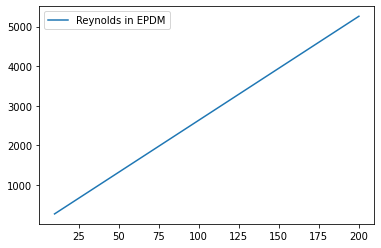

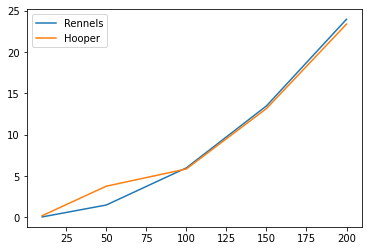

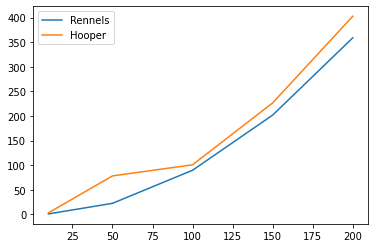

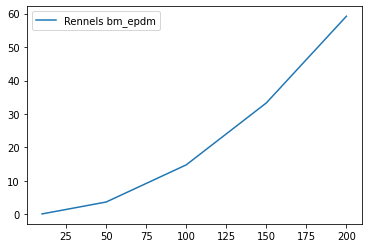

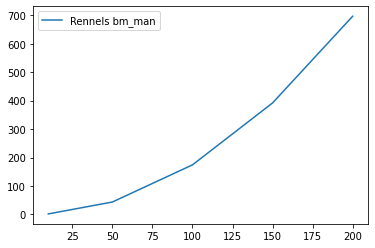

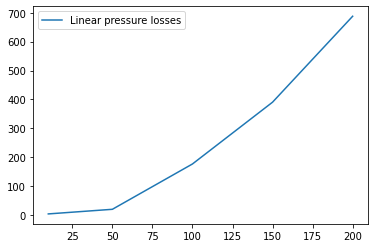

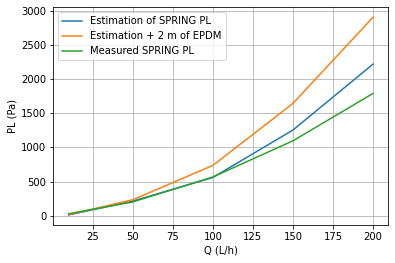

In [138]:
list_Re = []

Kc_list_R = []
Kc_list_H = []
PL_c_R = []
PL_c_H = []

Kdm_list_R = []
Kdm_list_H = []
PL_dm_R = []
PL_dm_H = []

Kcm_list_R = []
Kcm_list_H = []
PL_cm_R = []
PL_cm_H = []

Kd_list_R = []
Kd_list_H = []
PL_d_R = []
PL_d_H = []

list_Kbm_man = []
PL_bm_man = []

list_Kbm_epdm = []
PL_bm_epdm = []

PL_epdm = []

for Q in list_Q:
    u_epdm = Q/(math.pi*(d_epdm/2)**2)
    u_red = Q/(math.pi*(d_red/2)**2)
    u_man = Q/(math.pi*(d_man/2)**2)

    # Reynolds dans les liaisons EPDM, dans la réduction du QDF, dans les manifolds
    Re_epdm = fds.core.Reynolds(u_epdm,d_epdm,par["rho"],mu=par["eta"])
    list_Re.append(Re_epdm)
    Re_red = fds.core.Reynolds(u_red,d_red,par["rho"],mu=par["eta"])
    Re_man = fds.core.Reynolds(u_man,d_man,par["rho"],mu=par["eta"])

    # Contraction sharp EPDM-reduction
    Kc_H = fds.fittings.contraction_sharp(d_epdm,d_red,Re=Re_epdm,roughness=par["rough"],method='Hooper')
    Kc_R = fds.fittings.contraction_sharp(d_epdm,d_red,Re=Re_epdm,roughness=par["rough"],method='Rennels')
    Kc_list_H.append(Kc_H)
    Kc_list_R.append(Kc_R)
    PL_c_H.append((par["rho"]/2)*Kc_H*u_epdm**2)
    PL_c_R.append((par["rho"]/2)*Kc_R*u_epdm**2)

    # Diffuser sharp reduction-man
    Kdm_H = fds.fittings.diffuser_sharp(d_red,d_man,Re=Re_red,roughness=par["rough"],method='Hooper')
    Kdm_R = fds.fittings.diffuser_sharp(d_red,d_man,Re=Re_red,roughness=par["rough"],method='Rennels')
    Kdm_list_H.append(Kdm_H)
    Kdm_list_R.append(Kdm_R)
    PL_dm_H.append((par["rho"]/2)*Kdm_H*u_red**2)
    PL_dm_R.append((par["rho"]/2)*Kdm_R*u_red**2)

    # Contraction sharp manifold-reduction

    Kcm_H = fds.fittings.contraction_sharp(d_man,d_red,Re=Re_man,roughness=par["rough"],method='Hooper')
    Kcm_R = fds.fittings.contraction_sharp(d_man,d_red,Re=Re_man,roughness=par["rough"],method='Rennels')
    Kcm_list_H.append(Kcm_H)
    Kcm_list_R.append(Kcm_R)
    PL_cm_H.append((par["rho"]/2)*Kcm_H*u_man**2)
    PL_cm_R.append((par["rho"]/2)*Kcm_R*u_man**2)

    # Diffuser sharp reduction-EPDM
    Kd_H = fds.fittings.diffuser_sharp(d_red,d_epdm,Re=Re_red,roughness=par["rough"],method='Hooper')
    Kd_R = fds.fittings.diffuser_sharp(d_red,d_epdm,Re=Re_red,roughness=par["rough"],method='Rennels')
    Kd_list_H.append(Kd_H)
    Kd_list_R.append(Kd_R)
    PL_d_H.append((par["rho"]/2)*Kd_H*u_red**2)
    PL_d_R.append((par["rho"]/2)*Kd_R*u_red**2)

    # Bend miter in the EPDM
    Kbm_epdm = fds.fittings.bend_miter(angle_bm_epdm, Di=d_epdm, Re=fds.core.Reynolds(u_epdm,d_epdm,par["rho"],mu=par["eta"]),roughness=par["rough"], L_unimpeded=d_epdm, method='Rennels')
    list_Kbm_epdm.append(Kbm_epdm)
    PL_bm_epdm.append((par["rho"]/2)*Kbm_epdm*u_epdm**2)

    # Bend miter in the manifold
    Kbm = fds.fittings.bend_miter(angle_bm_man, Di=d_man, Re=Re_man, L_unimpeded=2*d_man, method='Rennels')
    list_Kbm_man.append(Kbm)
    PL_bm_man.append((par["rho"]/2)*Kbm*u_man**2)

    # Linear pressure losses

    f_epdm = fds.friction.friction_factor(Re = Re_epdm,eD=par["rough"]/d_epdm)
    K_lin_epdm = f_epdm*(L_epdm/d_epdm)
    PL_epdm.append((par["rho"]/2)*K_lin_epdm*u_epdm**2)

# Total pressure losses

exp_PL_tot = [(3.3*1E-5*Q**2+0.002363466*Q)*1000 for Q in list_Q_L]

PL_tot = np.array(PL_c_H) + np.array(PL_dm_H) + np.array(PL_d_H) + np.array(PL_cm_H) + 2*np.array(PL_bm_epdm) + 2*np.array(PL_bm_man) + np.array(list_PL)
PL_tot_lin = PL_tot + np.array(PL_epdm)

print(list_Q_L)
print(exp_PL_tot)
print(PL_tot)

plt.plot(list_Q_L,list_Re,label='Reynolds in EPDM')
plt.legend()
plt.show()

plt.plot(list_Q_L,PL_c_R,label='Rennels')
plt.plot(list_Q_L,PL_c_H,label='Hooper')
plt.legend()
plt.show()

plt.plot(list_Q_L,PL_d_R,label='Rennels')
plt.plot(list_Q_L,PL_d_H,label='Hooper')
plt.legend()
plt.show()

plt.plot(list_Q_L,PL_bm_epdm,label='Rennels bm_epdm')
plt.legend()
plt.show()

plt.plot(list_Q_L,PL_bm_man,label='Rennels bm_man')
plt.legend()
plt.show()

plt.plot(list_Q_L,PL_epdm,label='Linear pressure losses')
plt.legend()
plt.show()

plt.plot(list_Q_L,PL_tot,label='Estimation of SPRING PL')
plt.plot(list_Q_L,PL_tot_lin,label='Estimation + 2 m of EPDM')
plt.plot(list_Q_L,exp_PL_tot,label='Measured SPRING PL')
plt.legend()
plt.xlabel('Q (L/h)')
plt.ylabel('PL (Pa)')
plt.grid()
plt.show()


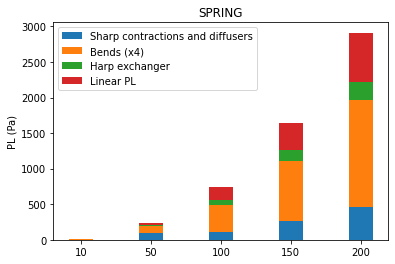

In [139]:
# Stacked bars chart

labels = ['10', '50', '100', '150', '200']

# cont_diff = np.array(PL_c_R) + np.array(PL_dm_R) + np.array(PL_d_R) + np.array(PL_cm_R)
cont_diff = np.array(PL_c_H) + np.array(PL_dm_H) + np.array(PL_d_H) + np.array(PL_cm_H)
bends = 2*np.array(PL_bm_epdm) + 2*np.array(PL_bm_man)
harp = np.array(list_PL)
reg = np.array(PL_epdm)

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, cont_diff, width, label='Sharp contractions and diffusers')
ax.bar(labels, bends, width, bottom=cont_diff,label='Bends (x4)')
ax.bar(labels, harp, width, bottom=cont_diff+bends,label='Harp exchanger')
ax.bar(labels, reg, width, bottom=cont_diff+bends+harp,label='Linear PL')

ax.set_ylabel('PL (Pa)')
ax.set_title('SPRING')
ax.legend()

plt.show()

In [130]:
save = [PL_tot,PL_tot_lin,exp_PL_tot,cont_diff,bends,harp,reg]

In [152]:
save2 = [PL_tot,PL_tot_lin,exp_PL_tot,cont_diff,bends,harp,reg]

C:\Users\valen\AppData\Local\Temp/ipykernel_7344/2083359350.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


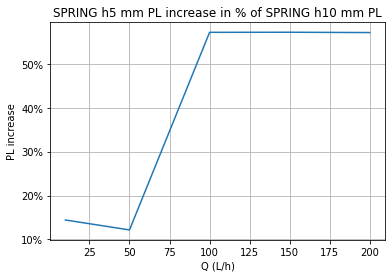

In [147]:
ratio = (PL_tot_lin-save[1])/save[1]

plt.plot(list_Q_L,ratio)
plt.xlabel('Q (L/h)')
plt.ylabel('PL increase')
plt.title('SPRING h5 mm PL increase in % of SPRING h10 mm PL')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.grid()
plt.show()

In [11]:
plt.plot(list_Q_L,PL_tot,label='Total pressure losses')

plt.legend()
plt.xlabel('Q (L/h)')
plt.ylabel('Re')

plt.grid()

NameError: name 'PL_tot' is not defined

In [12]:
print(list_Q_L)
print(list_PL)
print(list_mn)
print([list_Q_L[i]/par["N"] for i in range(len(list_Q_L))])

# df_res = pd.DataFrame([np.array(list_Q_L),np.array(list_PL)],columns = ['Q_L','PL (Pa)'])
# display(HTML(df_res.to_html()))  


[ 10.  50. 100. 150. 200.]
[0.7665524783605712, 5.177933741596064, 16.11781138319649, 37.0269098442076, 63.667653774741716]
[0.060606060606060566, 0.3030303030303029, 0.6060606060606062, 0.9090909090909091, 1.20836501436783]
[0.06060606060606061, 0.30303030303030304, 0.6060606060606061, 0.9090909090909091, 1.2121212121212122]


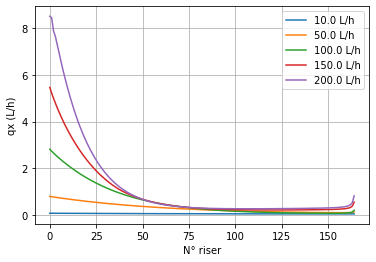

In [14]:
# Répartition des débits par canal (en valeur absolue)

list_Q_L_round = [round(num, 0) for num in list_Q_L]
risers = np.linspace(0,par["N"]-1,par["N"])

for i in range(len(list_tabl)):
    plt.plot(risers,np.array(list_tabl[i]['qx']),label=str(list_Q_L_round[i])+' L/h')
    plt.legend()

plt.xlabel('N° riser')
plt.ylabel('qx (L/h)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

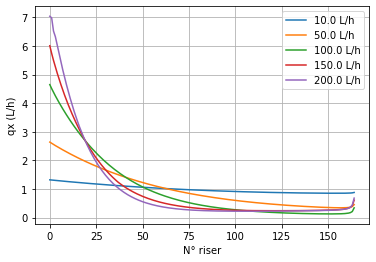

In [15]:
# Répartition des débits par canal (en valeur relative au débit moyen attendu)

for i in range(len(list_tabl)):
    plt.plot(risers,np.array(list_tabl[i]['qx'])/list_mn[i],label=str(list_Q_L_round[i])+' L/h')
    plt.legend()

plt.xlabel('N° riser')
plt.ylabel('qx (L/h)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

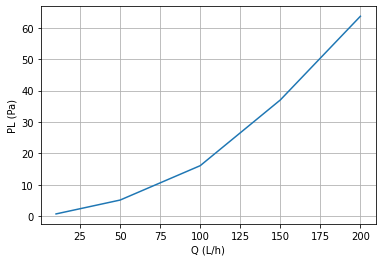

In [16]:
# Plot pressure losses

plt.plot(np.array(list_Q_L),np.array(list_PL))

plt.xlabel('Q (L/h)')
plt.ylabel('PL (Pa)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

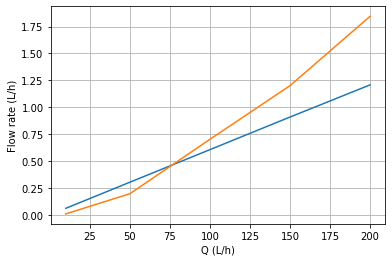

In [17]:
# Plot mean and standard deviation of flow rate

plt.plot(np.array(list_Q_L),np.array(list_mn))
plt.plot(np.array(list_Q_L),np.array(list_std))

plt.xlabel('Q (L/h)')
plt.ylabel('Flow rate (L/h)')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

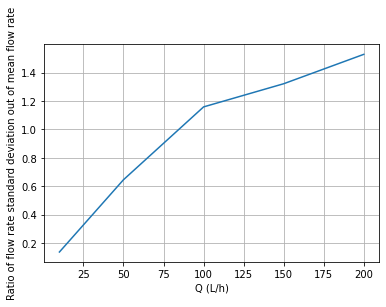

In [18]:
# Plot standard deviation of flow rate / mean flow rate

plt.plot(np.array(list_Q_L),np.array(list_std)/np.array(list_mn))

plt.xlabel('Q (L/h)')
plt.ylabel('Ratio of flow rate standard deviation out of mean flow rate')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

plt.show()

In [31]:
print(np.array(list_std))
print(np.array(list_mn))
print(np.array(list_std)/np.array(list_mn))

[0.01723904 0.18600567 0.54441504 0.98270781 1.43429627]
[0.06060606 0.34848485 0.63636364 0.92424023 1.21212121]
[0.2844441  0.53375541 0.85550934 1.06326016 1.18329442]


In [17]:
df = pd.DataFrame([1,2,3,4],columns = ['numbers'])

In [12]:
l = [2,2,2]
l = np.array(l)

In [13]:
l/2

array([1., 1., 1.])

In [19]:
np.array(list_tabl[0]['qx'])

array([0.07624329, 0.07593151, 0.07562993, 0.07533479, 0.07504424,
       0.07475734, 0.07447357, 0.07419262, 0.07391429, 0.07363844,
       0.07336498, 0.07309384, 0.07282497, 0.07255832, 0.07229386,
       0.07203157, 0.07177141, 0.07151337, 0.07125743, 0.07100357,
       0.07075178, 0.07050204, 0.07025434, 0.07000867, 0.06976502,
       0.06952337, 0.06928371, 0.06904604, 0.06881034, 0.06857661,
       0.06834482, 0.06811499, 0.06788708, 0.06766111, 0.06743704,
       0.06721489, 0.06699464, 0.06677628, 0.06655979, 0.06634519,
       0.06613245, 0.06592156, 0.06571253, 0.06550533, 0.06529997,
       0.06509644, 0.06489472, 0.06469481, 0.0644967 , 0.06430039,
       0.06410586, 0.06391311, 0.06372213, 0.06353292, 0.06334546,
       0.06315975, 0.06297578, 0.06279355, 0.06261304, 0.06243425,
       0.06225718, 0.06208181, 0.06190814, 0.06173616, 0.06156587,
       0.06139725, 0.06123031, 0.06106503, 0.0609014 , 0.06073943,
       0.0605791 , 0.06042041, 0.06026334, 0.06010791, 0.05995

In [20]:
risers = np.linspace(0,165,166)

In [24]:
len(np.array(list_tabl[i]['qx']))

165

In [25]:
len(risers)

166

In [31]:
print(list_Q_L)

[10.0, 57.50000000000001, 105.00000000000001, 152.5, 200.0]


In [33]:
[round(num, 0) for num in list_Q_L]

[10.0, 58.0, 105.0, 152.0, 200.0]